In [1]:
from PIL import Image
import numpy as np 
import os 


import numpy as np
import matplotlib.pyplot as pl
import torch
import ot
import ot.plot

import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# Enable interactive mode
%matplotlib ipympl
os.environ["CUDA_VISIBLE_DEVICES"] = "0"

## Load data

In [167]:
loaded_data = np.load("/home/dimakot55/output_data/gs_my/GT_lego_spheres_v5_clusters_100/cluster_51.npz") # 51, 36, 49, 24, 40,  45, 22, 20, 3, 32, 25,  19, 16, 17, 15, 13, 14

# Access the arrays by their names
gaussians_xyz = loaded_data['_xyz']
gaussians_features_dc = loaded_data['_features_dc']
gaussians_features_rest = loaded_data['_features_rest']
gaussians_rotation = loaded_data['_rotation']
gaussians_scaling = loaded_data['_scaling']
gaussians_opacity = loaded_data['_opacity']


## Preprocess data and visualize

In [168]:
# 1. Remove poitns that are too far away from all othe points. These are just noise
# Compute all pairwise distances between points
from scipy.spatial import distance
k=30
pairwise_distances = distance.cdist(gaussians_xyz, gaussians_xyz, 'euclidean')
# Use np.partition to find the k-th smallest distances for each row
kth_nearest_indices = np.argpartition(pairwise_distances, k, axis=1)[:, :k]
kth_nearest_distances = np.take_along_axis(pairwise_distances, kth_nearest_indices, axis=1)
q_outliers = np.quantile(np.max(kth_nearest_distances, axis=-1), 0.925)
idcs_relevant = np.where(np.max(kth_nearest_distances, axis=-1) < q_outliers)[0]
gaussians_xyz = loaded_data['_xyz'][idcs_relevant]
gaussians_features_dc = loaded_data['_features_dc'][idcs_relevant]
gaussians_features_rest = loaded_data['_features_rest'][idcs_relevant]
gaussians_rotation = loaded_data['_rotation'][idcs_relevant]
gaussians_scaling = loaded_data['_scaling'][idcs_relevant]
gaussians_opacity = loaded_data['_opacity'][idcs_relevant]

# preprocess colors
colors = np.array(gaussians_features_dc[:,0])
colors = (colors - np.min(colors)) / (np.max(colors) - np.min(colors))

# preprocess sizes. Transform scaling to a format somewhat acceptable 
# by the ax.scatter function
sizes = np.array(gaussians_scaling[:,0])
q05 = np.quantile(sizes, 0.5)
#sizes = sizes * (sizes > q05)
sizes = -sizes * 4. 

# Transform opacity to the format acceptable by ax.scatter
alpha = np.array(gaussians_opacity[:,0])
#alpha = alpha / np.max(alpha)
alpha = np.clip(alpha, 0., 1.)



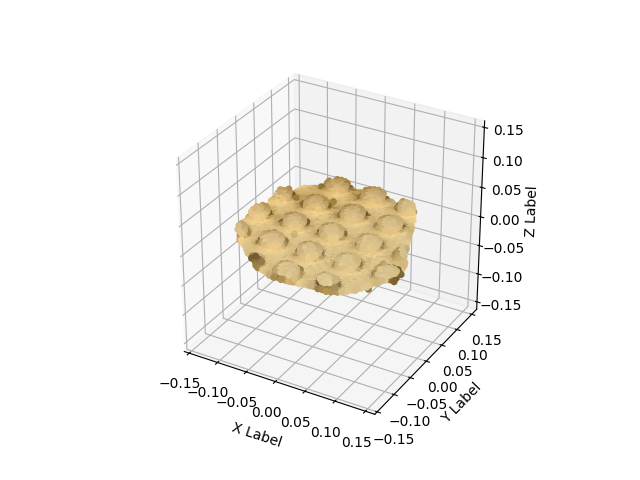

In [169]:

# Functions from @Mateen Ulhaq and @karlo
def set_axes_equal(ax: plt.Axes):
    """Set 3D plot axes to equal scale.

    Make axes of 3D plot have equal scale so that spheres appear as
    spheres and cubes as cubes.  Required since `ax.axis('equal')`
    and `ax.set_aspect('equal')` don't work on 3D.
    """
    limits = np.array([
        ax.get_xlim3d(),
        ax.get_ylim3d(),
        ax.get_zlim3d(),
    ])
    origin = np.mean(limits, axis=1)
    radius = 0.5 * np.max(np.abs(limits[:, 1] - limits[:, 0]))
    _set_axes_radius(ax, origin, radius)

def _set_axes_radius(ax, origin, radius):
    x, y, z = origin
    ax.set_xlim3d([x - radius, x + radius])
    ax.set_ylim3d([y - radius, y + radius])
    ax.set_zlim3d([z - radius, z + radius])


# Create a 3D scatter plot
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
#ax.axis('equal')
#ax.set_aspect('equal')
# Plot the scatter points
ax.scatter(gaussians_xyz[:,0], 
           gaussians_xyz[:,1], 
           gaussians_xyz[:,2], 
           c=np.concatenate([colors, alpha[:,None]], axis=-1),# c='b', 
           marker='o',
           s=sizes, #s=25.,
           #alpha=alpha,
           depthshade=False,
           edgecolors='none')
           #fillstyle='full',
           #markeredgecolor='red',
           #markeredgewidth=0.0)

# Set labels for the axes
ax.set_xlabel('X Label')
ax.set_ylabel('Y Label')
ax.set_zlabel('Z Label')
ax.set_box_aspect([1,1,1]) # IMPORTANT - this is the new, key line
# ax.set_proj_type('ortho') # OPTIONAL - default is perspective (shown in image above)
set_axes_equal(ax) # IMPORTANT - this is also required
plt.show()

# Optimization
## Aux functions computing descriptors

In [170]:
def get_descriptors(X, X_nns_indices):
    """
    Returns a matrix of distances between all points specified in the X_nns_indices matrix.
    :param X: tensor or shape [N,d]
    :param X_nns_indices: tensor of shape [N,k]
    :return 
        distances_nns : tensor of shape [N, k,k] with pairwise distances between all of the 
            k NNs for every sample in X.
    """
    
    X_nns = X[X_nns_indices]
    # All pairs can be too much
    # distances_nns = torch.norm(X_nns.unsqueeze(1) - X_nns.unsqueeze(2), dim=-1)
    # Just take all distances to the nearest neighbors
    distances_nns = torch.norm(X_nns[:,1:] - X_nns[:,0].unsqueeze(1), dim=-1)
    return distances_nns

def get_loss_domain_adaptation(X, domain, domain_NNs=20):
    """
    Try to approximate every point from X to the point from domain
    """
    
    D_to_domain = torch.cdist(X, domain)
    #print("D_to_domain.shape:", D_to_domain.shape)
    sorted_values, _ = torch.sort(D_to_domain, dim=1)  # Sort each row along dimension 1
    D_to_domain_mask = (D_to_domain <= sorted_values[:, domain_NNs - 1:domain_NNs])
    D_to_domain_mask = D_to_domain_mask.to(dtype=torch.float32)
    loss_D_to_domain = torch.mean(torch.square(D_to_domain)*D_to_domain_mask)
    # loss_D_to_domain = torch.mean(D_to_domain)
    return loss_D_to_domain

In [171]:
loaded_data_old = np.load("clusters.npz")

gaussians_shape_xyz = loaded_data_old['gaussians_shape_xyz']

In [174]:
device="cuda"
target_points_torch = torch.tensor(gaussians_xyz[alpha>0.5], device=device)
target_points_torch = torch.tensor(gaussians_xyz, device=device)
domain_points_torch = torch.tensor(loaded_data_old['gaussians_shape_xyz'], device=device) / torch.mean(torch.linalg.norm(target_points_torch))
# Old version with randomly initialized vector
points_torch = torch.nn.Parameter(torch.randn_like(target_points_torch, device=device)) 

# Compute nearest neighbors and target descriptors for both points and vecs
num_nns = 2000
distances = torch.cdist(target_points_torch, target_points_torch)
_, nns_indices = torch.topk(distances, k=num_nns, largest=False, dim=-1)
target_descriptor_points = get_descriptors(X=target_points_torch, X_nns_indices=nns_indices)
print("target_descriptor_points.shape:", target_descriptor_points.shape)

# Now add even stronger local loss
num_nns = 100
_, nns_indices_local = torch.topk(distances, k=num_nns, largest=False, dim=-1)
target_descriptor_points_local = get_descriptors(X=target_points_torch, X_nns_indices=nns_indices_local)
print("target_descriptor_points.shape:", target_descriptor_points.shape)


optimizer = torch.optim.Adam([points_torch], lr=1e-1)

for iter in range(1001):
    descriptor_points = get_descriptors(X=points_torch, X_nns_indices=nns_indices)
    loss_points_local = torch.mean(torch.square(descriptor_points - target_descriptor_points))#*D_pairwise_target_mask)
    
    descriptor_points2 = get_descriptors(X=points_torch, X_nns_indices=nns_indices_local)
    loss_points_local2 = torch.mean(torch.square(descriptor_points2 - target_descriptor_points_local))#*D_pairwise_target_mask)
    
    loss_domain = get_loss_domain_adaptation(X=points_torch, domain=domain_points_torch)
    
    loss = loss_points_local*5e0 + loss_points_local2*1e2 + loss_domain * 3e2
    
    loss.backward()
    optimizer.step()
    optimizer.zero_grad()
    if iter % 100 == 0:
        print(f"loss_points_local:{loss_points_local:.7f}, loss_points_local2:{loss_points_local2:.7f}, loss_domain:{loss_domain:.7f}")
        

target_descriptor_points.shape: torch.Size([2716, 1999])
target_descriptor_points.shape: torch.Size([2716, 1999])
loss_points_local:5.7956834, loss_points_local2:6.1595144, loss_domain:0.0106827
loss_points_local:0.0013583, loss_points_local2:0.0000701, loss_domain:0.0000658
loss_points_local:0.0001665, loss_points_local2:0.0000080, loss_domain:0.0000351
loss_points_local:0.0000858, loss_points_local2:0.0000041, loss_domain:0.0000222
loss_points_local:0.0000378, loss_points_local2:0.0000018, loss_domain:0.0000114
loss_points_local:0.0000144, loss_points_local2:0.0000008, loss_domain:0.0000050
loss_points_local:0.0000066, loss_points_local2:0.0000004, loss_domain:0.0000022
loss_points_local:0.0000046, loss_points_local2:0.0000002, loss_domain:0.0000013
loss_points_local:0.0000041, loss_points_local2:0.0000002, loss_domain:0.0000011
loss_points_local:0.0000040, loss_points_local2:0.0000002, loss_domain:0.0000010
loss_points_local:0.0000040, loss_points_local2:0.0000002, loss_domain:0.000

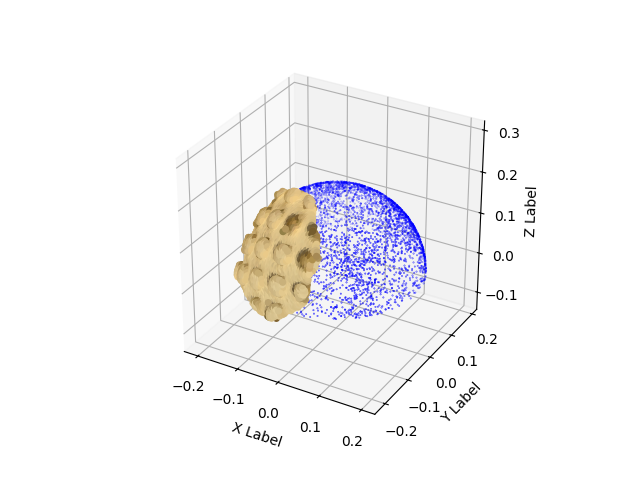

In [175]:

# Create a 3D scatter plot
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
#ax.axis('equal')
ax.set_aspect('equal')
# Plot target shape

# Plot the scatter points
arr_shape = domain_points_torch.detach().cpu().numpy()
ax.scatter(arr_shape[:,0], 
           arr_shape[:,1], 
           arr_shape[:,2], c='b', marker='o',s=0.1)


# Plot optimized points
arr = target_points_torch.detach().cpu().numpy()
arr = points_torch.detach().cpu().numpy()

ax.scatter(arr[:,0], 
           arr[:,1], 
           arr[:,2], 
           c=np.concatenate([colors, alpha[:,None]], axis=-1),# c='b', 
           marker='o',
           s=sizes, #s=25.,
           #alpha=alpha,
           depthshade=False,
           edgecolors='none')
           #fillstyle='full',
           #markeredgecolor='red',
           #markeredgewidth=0.0)

# Set labels for the axes
ax.set_xlabel('X Label')
ax.set_ylabel('Y Label')
ax.set_zlabel('Z Label')

ax.set_box_aspect([1,1,1]) # IMPORTANT - this is the new, key line
# ax.set_proj_type('ortho') # OPTIONAL - default is perspective (shown in image above)
set_axes_equal(ax) # IMPORTANT - this is also required
plt.show()



In [25]:
nns_indices.shape

torch.Size([2196, 2000])

In [27]:
nns_indices[:, ::40]

tensor([[   0, 2071,  356,  ...,  910, 1864, 1863],
        [   1, 1428,  995,  ..., 1570,   19,  395],
        [   2,  861,  230,  ..., 2059,  382,  990],
        ...,
        [2193, 1684,  697,  ...,  301, 1857, 1386],
        [2194,  210,  429,  ...,  119, 1448,  421],
        [2195,  350, 1377,  ...,  639, 1041, 1126]], device='cuda:0')

In [184]:
device="cuda"
target_points_torch = torch.tensor(gaussians_xyz, device=device)
domain_points_torch = torch.tensor(loaded_data_old['gaussians_shape_xyz'], device=device) / torch.mean(torch.linalg.norm(target_points_torch))
# Old version with randomly initialized vector

#points_torch = torch.nn.Parameter(torch.randn_like(target_points_torch, device=device)) 

points_torch_list = [torch.nn.Parameter(torch.randn_like(target_points_torch, device=device)) for _ in range(8)]

# Compute nearest neighbors and target descriptors for both points and vecs
num_nns = 2000
distances = torch.cdist(target_points_torch, target_points_torch)
_, nns_indices = torch.topk(distances, k=num_nns, largest=False, dim=-1)
target_descriptor_points = get_descriptors(X=target_points_torch, X_nns_indices=nns_indices[:, ::40])
print("target_descriptor_points.shape:", target_descriptor_points.shape)

# Now add even stronger local loss
num_nns = 100
_, nns_indices_local = torch.topk(distances, k=num_nns, largest=False, dim=-1)
target_descriptor_points_local = get_descriptors(X=target_points_torch, X_nns_indices=nns_indices_local[:, ::5])
print("target_descriptor_points.shape:", target_descriptor_points.shape)


optimizer = torch.optim.Adam(points_torch_list, lr=1e-1)

for iter in range(1001):
    loss = 0.
    loss_points_local = 0.
    loss_points_local2 = 0.
    loss_domain = 0.
    loss_domain_coverage = 0.
    for points_torch in points_torch_list:
        descriptor_points = get_descriptors(X=points_torch, X_nns_indices=nns_indices[:, ::40])
        loss_points_local += torch.mean(torch.square(descriptor_points - target_descriptor_points))#*D_pairwise_target_mask)
        
        descriptor_points2 = get_descriptors(X=points_torch, X_nns_indices=nns_indices_local[:, ::5])
        loss_points_local2 += torch.mean(torch.square(descriptor_points2 - target_descriptor_points_local))#*D_pairwise_target_mask)
        
        loss_domain += get_loss_domain_adaptation(X=points_torch, domain=domain_points_torch)

    domain_to_cluster_D = torch.stack([torch.min(torch.cdist(domain_points_torch, points_torch_list[i]) , dim=-1)[0]
           for i in range(len(points_torch_list))], dim=1)
    loss_domain_coverage = torch.mean(torch.min(domain_to_cluster_D, axis=-1)[0])
    loss = loss_points_local*5e0 + loss_points_local2*1e2 + loss_domain * 3e2 + loss_domain_coverage * 0e0
    
    loss.backward()
    optimizer.step()
    optimizer.zero_grad()
    if iter % 100 == 0:
        print(f"loss_points_local:{loss_points_local:.7f}", 
              f"loss_points_local2:{loss_points_local2:.7f}", 
              f"loss_domain:{loss_domain:.7f}",
              f"loss_domain_coverage:{loss_domain_coverage:.7f}"
              )
        

target_descriptor_points.shape: torch.Size([2716, 49])
target_descriptor_points.shape: torch.Size([2716, 49])
loss_points_local:44.3840675 loss_points_local2:47.3767815 loss_domain:0.0814652 loss_domain_coverage:0.0592820
loss_points_local:0.0192167 loss_points_local2:0.0005585 loss_domain:0.0005066 loss_domain_coverage:0.0731045
loss_points_local:0.0035300 loss_points_local2:0.0000746 loss_domain:0.0002633 loss_domain_coverage:0.0374230
loss_points_local:0.0018811 loss_points_local2:0.0000375 loss_domain:0.0001520 loss_domain_coverage:0.0248738
loss_points_local:0.0012414 loss_points_local2:0.0000207 loss_domain:0.0000836 loss_domain_coverage:0.0184824
loss_points_local:0.0007398 loss_points_local2:0.0000116 loss_domain:0.0000478 loss_domain_coverage:0.0133996
loss_points_local:0.0003204 loss_points_local2:0.0000064 loss_domain:0.0000292 loss_domain_coverage:0.0098827
loss_points_local:0.0001451 loss_points_local2:0.0000039 loss_domain:0.0000184 loss_domain_coverage:0.0073603
loss_poi

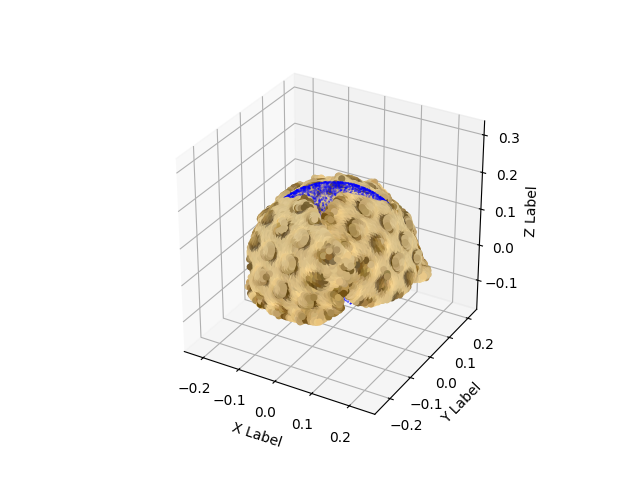

In [185]:


# Create a 3D scatter plot
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
#ax.axis('equal')
ax.set_aspect('equal')
# Plot target shape

# Plot the scatter points
arr_shape = domain_points_torch.detach().cpu().numpy()
ax.scatter(arr_shape[:,0], 
           arr_shape[:,1], 
           arr_shape[:,2], c='b', marker='o',s=0.1)


# Plot optimized points
arr = target_points_torch.detach().cpu().numpy()
for points_torch in points_torch_list:
    arr = points_torch.detach().cpu().numpy()
    
    ax.scatter(arr[:,0], 
               arr[:,1], 
               arr[:,2], 
               c=np.concatenate([colors, alpha[:,None]], axis=-1),# c='b', 
               marker='o',
               s=sizes, #s=25.,
               #alpha=alpha,
               depthshade=False,
               edgecolors='none')
               #fillstyle='full',
               #markeredgecolor='red',
               #markeredgewidth=0.0)

# Set labels for the axes
ax.set_xlabel('X Label')
ax.set_ylabel('Y Label')
ax.set_zlabel('Z Label')

ax.set_box_aspect([1,1,1]) # IMPORTANT - this is the new, key line
# ax.set_proj_type('ortho') # OPTIONAL - default is perspective (shown in image above)
set_axes_equal(ax) # IMPORTANT - this is also required
plt.show()



In [178]:

for iter in range(1001):
    loss = 0.
    loss_points_local = 0.
    loss_points_local2 = 0.
    loss_domain = 0.
    loss_domain_coverage = 0.
    for points_torch in points_torch_list:
        descriptor_points = get_descriptors(X=points_torch, X_nns_indices=nns_indices[:, ::40])
        loss_points_local += torch.mean(torch.square(descriptor_points - target_descriptor_points))#*D_pairwise_target_mask)
        
        descriptor_points2 = get_descriptors(X=points_torch, X_nns_indices=nns_indices_local[:, ::5])
        loss_points_local2 += torch.mean(torch.square(descriptor_points2 - target_descriptor_points_local))#*D_pairwise_target_mask)
        
        loss_domain += get_loss_domain_adaptation(X=points_torch, domain=domain_points_torch)

    domain_to_cluster_D = torch.stack([torch.min(torch.cdist(domain_points_torch, points_torch_list[i]) , dim=-1)[0]
           for i in range(len(points_torch_list))], dim=1)
    loss_domain_coverage = torch.mean(torch.min(domain_to_cluster_D, axis=-1)[0])
    loss = loss_points_local*2e0 + loss_points_local2*1e2 + loss_domain * 3e2
    
    loss.backward()
    optimizer.step()
    optimizer.zero_grad()
    if iter % 100 == 0:
        print(f"loss_points_local:{loss_points_local:.7f}", 
              f"loss_points_local2:{loss_points_local2:.7f}", 
              f"loss_domain:{loss_domain:.7f}",
              f"loss_domain_coverage:{loss_domain_coverage:.7f}"
              )
        

loss_points_local:0.0011782 loss_points_local2:0.0000147 loss_domain:0.0000195 loss_domain_coverage:0.0098492
loss_points_local:0.0011692 loss_points_local2:0.0000045 loss_domain:0.0000133 loss_domain_coverage:0.0177663
loss_points_local:0.0011660 loss_points_local2:0.0000039 loss_domain:0.0000105 loss_domain_coverage:0.0172344
loss_points_local:0.0011432 loss_points_local2:0.0000035 loss_domain:0.0000090 loss_domain_coverage:0.0166561
loss_points_local:0.0010975 loss_points_local2:0.0000032 loss_domain:0.0000082 loss_domain_coverage:0.0162639
loss_points_local:0.0010241 loss_points_local2:0.0000030 loss_domain:0.0000078 loss_domain_coverage:0.0160389
loss_points_local:0.0009244 loss_points_local2:0.0000029 loss_domain:0.0000076 loss_domain_coverage:0.0160285
loss_points_local:0.0008176 loss_points_local2:0.0000027 loss_domain:0.0000075 loss_domain_coverage:0.0159876
loss_points_local:0.0007221 loss_points_local2:0.0000026 loss_domain:0.0000073 loss_domain_coverage:0.0158162
loss_point

In [58]:

for iter in range(1001):
    loss = 0.
    loss_points_local = 0.
    loss_points_local2 = 0.
    loss_domain = 0.
    loss_domain_coverage = 0.
    for points_torch in points_torch_list:
        descriptor_points = get_descriptors(X=points_torch, X_nns_indices=nns_indices[:, ::40])
        loss_points_local += torch.mean(torch.square(descriptor_points - target_descriptor_points))#*D_pairwise_target_mask)
        
        descriptor_points2 = get_descriptors(X=points_torch, X_nns_indices=nns_indices_local[:, ::5])
        loss_points_local2 += torch.mean(torch.square(descriptor_points2 - target_descriptor_points_local))#*D_pairwise_target_mask)
        
        loss_domain += get_loss_domain_adaptation(X=points_torch, domain=domain_points_torch)

    domain_to_cluster_D = torch.stack([torch.min(torch.cdist(domain_points_torch, points_torch_list[i]) , dim=-1)[0]
           for i in range(len(points_torch_list))], dim=1)
    loss_domain_coverage = torch.mean(torch.min(domain_to_cluster_D, axis=-1)[0])
    loss = loss_points_local*2e0 + loss_points_local2*1e2 + loss_domain * 3e2 + loss_domain_coverage * 1e0
    
    loss.backward()
    optimizer.step()
    optimizer.zero_grad()
    if iter % 100 == 0:
        print(f"loss_points_local:{loss_points_local:.7f}", 
              f"loss_points_local2:{loss_points_local2:.7f}", 
              f"loss_domain:{loss_domain:.7f}",
              f"loss_domain_coverage:{loss_domain_coverage:.7f}"
              )
        

loss_points_local:0.0023198 loss_points_local2:0.0000136 loss_domain:0.0000702 loss_domain_coverage:0.0051420
loss_points_local:0.0019669 loss_points_local2:0.0000252 loss_domain:0.0000492 loss_domain_coverage:0.0028067
loss_points_local:0.0016072 loss_points_local2:0.0000232 loss_domain:0.0000399 loss_domain_coverage:0.0023163
loss_points_local:0.0012089 loss_points_local2:0.0000213 loss_domain:0.0000349 loss_domain_coverage:0.0019995
loss_points_local:0.0008660 loss_points_local2:0.0000195 loss_domain:0.0000318 loss_domain_coverage:0.0018161
loss_points_local:0.0006588 loss_points_local2:0.0000190 loss_domain:0.0000298 loss_domain_coverage:0.0017163
loss_points_local:0.0005457 loss_points_local2:0.0000185 loss_domain:0.0000285 loss_domain_coverage:0.0016277
loss_points_local:0.0004690 loss_points_local2:0.0000178 loss_domain:0.0000277 loss_domain_coverage:0.0015711
loss_points_local:0.0004163 loss_points_local2:0.0000171 loss_domain:0.0000271 loss_domain_coverage:0.0015528
loss_point

In [54]:

for iter in range(1001):
    loss = 0.
    loss_points_local = 0.
    loss_points_local2 = 0.
    loss_domain = 0.
    loss_domain_coverage = 0.
    for points_torch in points_torch_list:
        descriptor_points = get_descriptors(X=points_torch, X_nns_indices=nns_indices[:, ::40])
        loss_points_local += torch.mean(torch.square(descriptor_points - target_descriptor_points))#*D_pairwise_target_mask)
        
        descriptor_points2 = get_descriptors(X=points_torch, X_nns_indices=nns_indices_local[:, ::5])
        loss_points_local2 += torch.mean(torch.square(descriptor_points2 - target_descriptor_points_local))#*D_pairwise_target_mask)
        
        loss_domain += get_loss_domain_adaptation(X=points_torch, domain=domain_points_torch)

    domain_to_cluster_D = torch.stack([torch.min(torch.cdist(domain_points_torch, points_torch_list[i]) , dim=-1)[0]
           for i in range(len(points_torch_list))], dim=1)
    loss_domain_coverage = torch.mean(torch.min(domain_to_cluster_D, axis=-1)[0])
    loss = loss_points_local*2e0 + loss_points_local2*1e2 + loss_domain * 3e2 + loss_domain_coverage * 1e0
    
    loss.backward()
    optimizer.step()
    optimizer.zero_grad()
    if iter % 100 == 0:
        print(f"loss_points_local:{loss_points_local:.7f}", 
              f"loss_points_local2:{loss_points_local2:.7f}", 
              f"loss_domain:{loss_domain:.7f}",
              f"loss_domain_coverage:{loss_domain_coverage:.7f}"
              )
        

loss_points_local:0.0001487 loss_points_local2:0.0000184 loss_domain:0.0000160 loss_domain_coverage:0.0028754
loss_points_local:0.0001451 loss_points_local2:0.0000186 loss_domain:0.0000160 loss_domain_coverage:0.0027821
loss_points_local:0.0001419 loss_points_local2:0.0000184 loss_domain:0.0000160 loss_domain_coverage:0.0026826
loss_points_local:0.0001395 loss_points_local2:0.0000186 loss_domain:0.0000160 loss_domain_coverage:0.0026838
loss_points_local:0.0001381 loss_points_local2:0.0000189 loss_domain:0.0000160 loss_domain_coverage:0.0027058
loss_points_local:0.0001370 loss_points_local2:0.0000194 loss_domain:0.0000160 loss_domain_coverage:0.0026882
loss_points_local:0.0001363 loss_points_local2:0.0000217 loss_domain:0.0000160 loss_domain_coverage:0.0027091
loss_points_local:0.0001336 loss_points_local2:0.0000213 loss_domain:0.0000159 loss_domain_coverage:0.0027086
loss_points_local:0.0001311 loss_points_local2:0.0000230 loss_domain:0.0000159 loss_domain_coverage:0.0027525
loss_point

In [72]:

for iter in range(1001):
    loss = 0.
    loss_points_local = 0.
    loss_points_local2 = 0.
    loss_domain = 0.
    loss_domain_coverage = 0.
    for points_torch in points_torch_list:
        descriptor_points = get_descriptors(X=points_torch, X_nns_indices=nns_indices[:, ::40])
        loss_points_local += torch.mean(torch.square(descriptor_points - target_descriptor_points))#*D_pairwise_target_mask)
        
        descriptor_points2 = get_descriptors(X=points_torch, X_nns_indices=nns_indices_local[:, ::5])
        loss_points_local2 += torch.mean(torch.square(descriptor_points2 - target_descriptor_points_local))#*D_pairwise_target_mask)
        
        loss_domain += get_loss_domain_adaptation(X=points_torch, domain=domain_points_torch)

    domain_to_cluster_D = torch.stack([torch.min(torch.cdist(domain_points_torch, points_torch_list[i]) , dim=-1)[0]
           for i in range(len(points_torch_list))], dim=1)
    loss_domain_coverage = torch.mean(torch.min(domain_to_cluster_D, axis=-1)[0])
    loss = loss_points_local*2e0 + loss_points_local2*1e2 + loss_domain * 3e2
    
    loss.backward()
    optimizer.step()
    optimizer.zero_grad()
    if iter % 100 == 0:
        print(f"loss_points_local:{loss_points_local:.7f}", 
              f"loss_points_local2:{loss_points_local2:.7f}", 
              f"loss_domain:{loss_domain:.7f}",
              f"loss_domain_coverage:{loss_domain_coverage:.7f}"
              )
        

loss_points_local:0.0012394 loss_points_local2:0.0000186 loss_domain:0.0000255 loss_domain_coverage:0.0156769
loss_points_local:0.0003598 loss_points_local2:0.0000027 loss_domain:0.0000294 loss_domain_coverage:0.0286369
loss_points_local:0.0001296 loss_points_local2:0.0000014 loss_domain:0.0000318 loss_domain_coverage:0.0297456
loss_points_local:0.0000645 loss_points_local2:0.0000010 loss_domain:0.0000327 loss_domain_coverage:0.0300738
loss_points_local:0.0000399 loss_points_local2:0.0000009 loss_domain:0.0000331 loss_domain_coverage:0.0301842
loss_points_local:0.0000278 loss_points_local2:0.0000008 loss_domain:0.0000332 loss_domain_coverage:0.0302219
loss_points_local:0.0000206 loss_points_local2:0.0000007 loss_domain:0.0000333 loss_domain_coverage:0.0302364
loss_points_local:0.0000161 loss_points_local2:0.0000006 loss_domain:0.0000333 loss_domain_coverage:0.0302464
loss_points_local:0.0000129 loss_points_local2:0.0000006 loss_domain:0.0000333 loss_domain_coverage:0.0302583
loss_point

In [39]:
torch.min(torch.cdist(domain_points_torch, points_torch_list[2]) , dim=-1)[0]

tensor([0.1851, 0.1409, 0.0684,  ..., 0.2065, 0.0550, 0.0387], device='cuda:0',
       grad_fn=<MinBackward0>)

In [47]:
domain_to_cluster_D.shape

torch.Size([4893, 3])

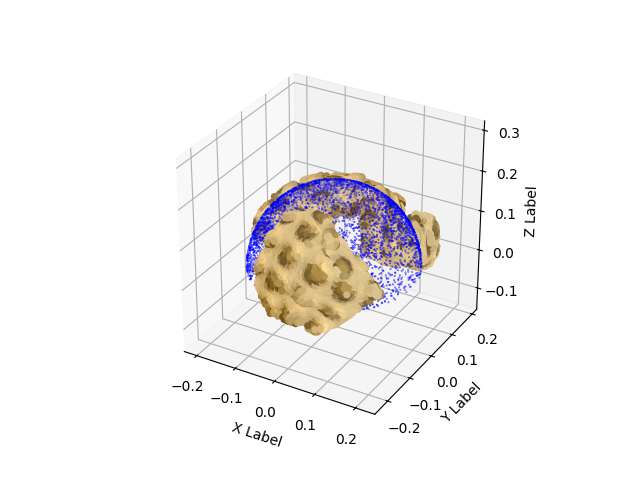

In [179]:


# Create a 3D scatter plot
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
#ax.axis('equal')
ax.set_aspect('equal')
# Plot target shape

# Plot the scatter points
arr_shape = domain_points_torch.detach().cpu().numpy()
ax.scatter(arr_shape[:,0], 
           arr_shape[:,1], 
           arr_shape[:,2], c='b', marker='o',s=0.1)


# Plot optimized points
arr = target_points_torch.detach().cpu().numpy()
for points_torch in points_torch_list:
    arr = points_torch.detach().cpu().numpy()
    
    ax.scatter(arr[:,0], 
               arr[:,1], 
               arr[:,2], 
               c=np.concatenate([colors, alpha[:,None]], axis=-1),# c='b', 
               marker='o',
               s=sizes, #s=25.,
               #alpha=alpha,
               depthshade=False,
               edgecolors='none')
               #fillstyle='full',
               #markeredgecolor='red',
               #markeredgewidth=0.0)

# Set labels for the axes
ax.set_xlabel('X Label')
ax.set_ylabel('Y Label')
ax.set_zlabel('Z Label')

ax.set_box_aspect([1,1,1]) # IMPORTANT - this is the new, key line
# ax.set_proj_type('ortho') # OPTIONAL - default is perspective (shown in image above)
set_axes_equal(ax) # IMPORTANT - this is also required
plt.show()



## Filter overlapping regions and remove points there.

In [ ]:
torch.torch.cdist(points_torch_list[0], points_torch_list[0])
_, nns_indices_local = torch.topk(distances, k=num_nns, largest=False, dim=-1)

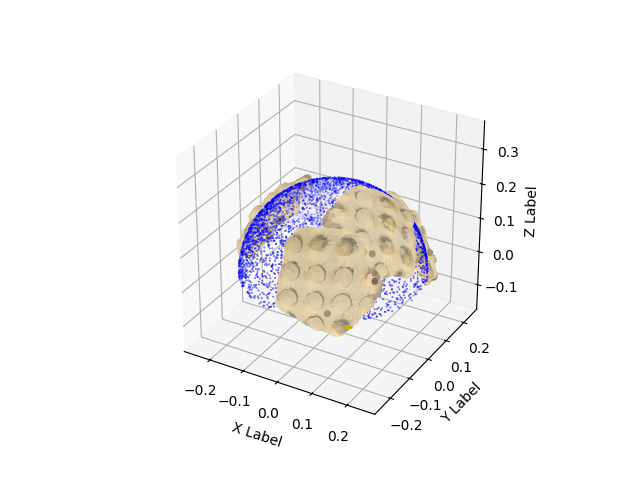

In [78]:


# Create a 3D scatter plot
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
#ax.axis('equal')
ax.set_aspect('equal')
# Plot target shape

# Plot the scatter points
arr_shape = domain_points_torch.detach().cpu().numpy()
ax.scatter(arr_shape[:,0], 
           arr_shape[:,1], 
           arr_shape[:,2], c='b', marker='o',s=0.1)


# Plot optimized points
arr = target_points_torch.detach().cpu().numpy()
for points_torch in points_torch_list:
    arr = points_torch.detach().cpu().numpy()
    
    ax.scatter(arr[:,0], 
               arr[:,1], 
               arr[:,2], 
               c=np.concatenate([colors, alpha[:,None]], axis=-1),# c='b', 
               marker='o',
               s=sizes, #s=25.,
               #alpha=alpha,
               depthshade=False,
               edgecolors='none')
               #fillstyle='full',
               #markeredgecolor='red',
               #markeredgewidth=0.0)

# Set labels for the axes
ax.set_xlabel('X Label')
ax.set_ylabel('Y Label')
ax.set_zlabel('Z Label')

ax.set_box_aspect([1,1,1]) # IMPORTANT - this is the new, key line
# ax.set_proj_type('ortho') # OPTIONAL - default is perspective (shown in image above)
set_axes_equal(ax) # IMPORTANT - this is also required
plt.show()



In [188]:
import sys
sys.path.append("../")

from scene import GaussianModel
MODEL_DIR = './GT_lego_cluster2/'
#os.makedirs(MODEL_DIR, exist_ok = True)
gaussians_to_save = GaussianModel(sh_degree=3)
#gaussians_to_save.restore(torch.load("/home/dimakot55/output_data/gs_my/gs/GT_lego_cluster2/chkpnt1.pth")[0], opt)
gaussians_to_save.optimizer = torch.optim.Adam([gaussians_to_save._xyz], lr=1e-1)



# gaussians_xyz = loaded_data['_xyz'][idcs_relevant]
# gaussians_features_dc = loaded_data['_features_dc'][idcs_relevant]
# gaussians_features_rest = loaded_data['_features_rest'][idcs_relevant]
# gaussians_rotation = loaded_data['_rotation'][idcs_relevant]
# gaussians_scaling = loaded_data['_scaling'][idcs_relevant]
# gaussians_opacity = loaded_data['_opacity'][idcs_relevant]

# Store optimized parameters to the gaussias_to_save
N = len(points_torch_list)
gaussians_to_save._xyz = torch.tensor(torch.concat(points_torch_list, dim=0).clone().detach())
# gaussians_to_save._xyz = torch.tensor(target_points_torch).clone().detach()
gaussians_to_save._rotation = torch.tensor(np.concatenate([gaussians_rotation]*N, axis=0))
gaussians_to_save._features_dc = torch.tensor(np.concatenate([gaussians_features_dc]*N, axis=0))
gaussians_to_save._features_rest = torch.tensor(np.concatenate([gaussians_features_rest*0.]*N, axis=0))
gaussians_to_save._scaling = torch.tensor(np.concatenate([gaussians_scaling*0.885]*N, axis=0)) #was 0.885
gaussians_to_save._opacity = torch.tensor(np.concatenate([gaussians_opacity]*N, axis=0))


iteration=1
torch.save((gaussians_to_save.capture(), iteration), MODEL_DIR + "/chkpnt" + str(iteration) + ".pth")
gaussians_to_save.save_ply(os.path.join(MODEL_DIR, "point_cloud/iteration_1/", "point_cloud.ply"))



/tmp/ipykernel_2543032/3084336330.py:22: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  gaussians_to_save._xyz = torch.tensor(torch.concat(points_torch_list, dim=0).clone().detach())


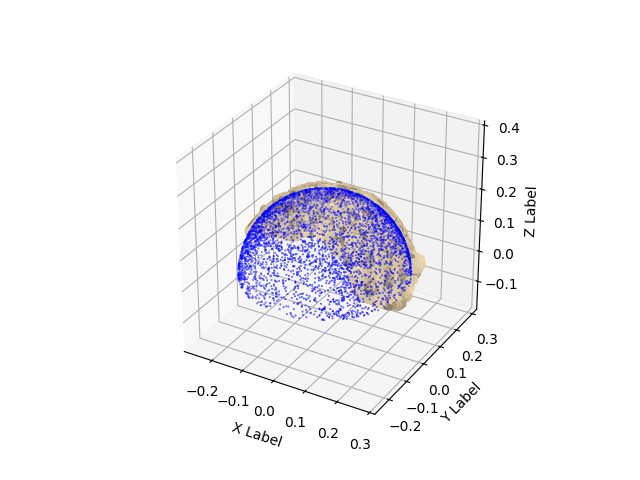

In [32]:

# Create a 3D scatter plot
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
#ax.axis('equal')
ax.set_aspect('equal')
# Plot target shape

# Plot the scatter points
arr_shape = domain_points_torch.detach().cpu().numpy()
ax.scatter(arr_shape[:,0], 
           arr_shape[:,1], 
           arr_shape[:,2], c='b', marker='o',s=0.1)


# Plot optimized points
arr = target_points_torch.detach().cpu().numpy()
for points_torch in points_torch_list:
    arr = points_torch.detach().cpu().numpy()
    
    ax.scatter(arr[:,0], 
               arr[:,1], 
               arr[:,2], 
               c=np.concatenate([colors, alpha[:,None]], axis=-1),# c='b', 
               marker='o',
               s=sizes, #s=25.,
               #alpha=alpha,
               depthshade=False,
               edgecolors='none')
               #fillstyle='full',
               #markeredgecolor='red',
               #markeredgewidth=0.0)

# Set labels for the axes
ax.set_xlabel('X Label')
ax.set_ylabel('Y Label')
ax.set_zlabel('Z Label')

ax.set_box_aspect([1,1,1]) # IMPORTANT - this is the new, key line
# ax.set_proj_type('ortho') # OPTIONAL - default is perspective (shown in image above)
set_axes_equal(ax) # IMPORTANT - this is also required
plt.show()



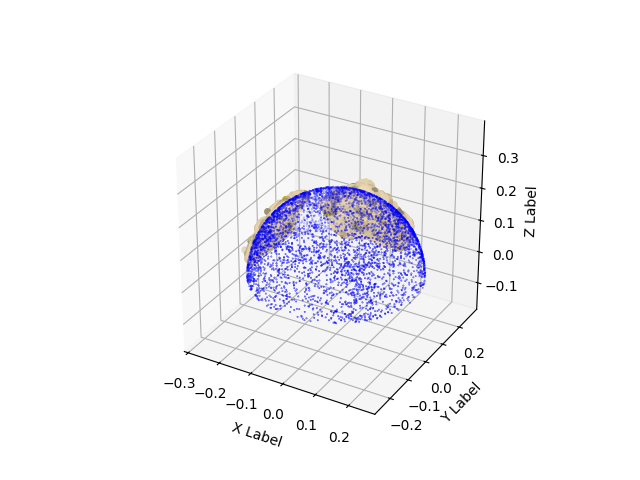

In [30]:

# Create a 3D scatter plot
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
#ax.axis('equal')
ax.set_aspect('equal')
# Plot target shape

# Plot the scatter points
arr_shape = domain_points_torch.detach().cpu().numpy()
ax.scatter(arr_shape[:,0], 
           arr_shape[:,1], 
           arr_shape[:,2], c='b', marker='o',s=0.1)


# Plot optimized points
arr = target_points_torch.detach().cpu().numpy()
for points_torch in points_torch_list:
    arr = points_torch.detach().cpu().numpy()
    
    ax.scatter(arr[:,0], 
               arr[:,1], 
               arr[:,2], 
               c=np.concatenate([colors, alpha[:,None]], axis=-1),# c='b', 
               marker='o',
               s=sizes, #s=25.,
               #alpha=alpha,
               depthshade=False,
               edgecolors='none')
               #fillstyle='full',
               #markeredgecolor='red',
               #markeredgewidth=0.0)

# Set labels for the axes
ax.set_xlabel('X Label')
ax.set_ylabel('Y Label')
ax.set_zlabel('Z Label')

ax.set_box_aspect([1,1,1]) # IMPORTANT - this is the new, key line
# ax.set_proj_type('ortho') # OPTIONAL - default is perspective (shown in image above)
set_axes_equal(ax) # IMPORTANT - this is also required
plt.show()



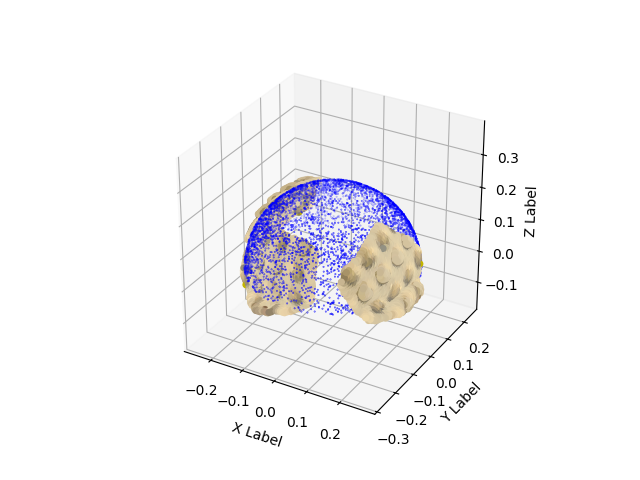

In [23]:

# Create a 3D scatter plot
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
#ax.axis('equal')
ax.set_aspect('equal')
# Plot target shape

# Plot the scatter points
arr_shape = domain_points_torch.detach().cpu().numpy()
ax.scatter(arr_shape[:,0], 
           arr_shape[:,1], 
           arr_shape[:,2], c='b', marker='o',s=0.1)


# Plot optimized points
arr = target_points_torch.detach().cpu().numpy()
for points_torch in points_torch_list:
    arr = points_torch.detach().cpu().numpy()
    
    ax.scatter(arr[:,0], 
               arr[:,1], 
               arr[:,2], 
               c=np.concatenate([colors, alpha[:,None]], axis=-1),# c='b', 
               marker='o',
               s=sizes, #s=25.,
               #alpha=alpha,
               depthshade=False,
               edgecolors='none')
               #fillstyle='full',
               #markeredgecolor='red',
               #markeredgewidth=0.0)

# Set labels for the axes
ax.set_xlabel('X Label')
ax.set_ylabel('Y Label')
ax.set_zlabel('Z Label')

ax.set_box_aspect([1,1,1]) # IMPORTANT - this is the new, key line
# ax.set_proj_type('ortho') # OPTIONAL - default is perspective (shown in image above)
set_axes_equal(ax) # IMPORTANT - this is also required
plt.show()

